In [1]:
! pip install pygbif


  Using cached https://files.pythonhosted.org/packages/7a/25/222531f22cf162409c38f55c48b13ab0c4128cf13ac05290de8878d639b1/pygbif-0.4.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/c9/81/156ca48f950f833ddc392f8e3677ca50a18cb9d5db38ccb4ecea55a9303f/geomet-0.2.1.post1-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/f7/5b/55fb64433477ebc983546e2d84ce04473b8750525dab67b2b18c6959a1ae/geojson_rewind-0.2.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/7f/55/9b1c40eb83c16d8fc79c5f6c2ffade04208b080670fbfc35e0a5effb5a92/requests_cache-0.5.2-py2.py3-none-any.whl


In [1]:
import os

import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.animation import FuncAnimation
sns.set_style('ticks', {'font_scale': 1.1})

import random
import numpy as np

import gcsfs

from datetime import timedelta, datetime

from functools import partial 

import cartopy.crs as ccrs
import cartopy.feature as cf

from tqdm import tqdm

import xarray as xr
from dask.distributed import Client

%matplotlib inline

PNW_LAT = slice(1.52, 63.4)
PNW_LON =slice(-170, -103)

import pygbif

ModuleNotFoundError: No module named 'pygbif'

In [ ]:
GCP_PROJECT_ID = '170771369993'
OISST_GCP = 'oisst/oisst.zarr'

# PNW Focal Species Sanity Check
We'll use GBIF to select a species with lots of occurrences in the PNW and assess the impact of MHWs on that species. 

In [3]:
plankton = pd.read_csv("../data/Phytoplankton_temperature_growth_rate_dataset_2016_01_29/traits_derived_2016_01_29.csv", engine='python')

In [4]:
plankton = plankton[(plankton.minqual == "good") &
                    (plankton.maxqual == "good") &
                    (plankton.curvequal == "good")]

In [5]:
plankton = plankton[plankton.habitat == 'marine']

In [6]:
print(len(plankton))
print(len(set(list(zip(plankton.genus, plankton.species)))))

96
62


In [7]:
plankton.genus.unique()

array(['Koliella', 'Klebsormidium', 'Phaeocystis', 'Pseudo-nitzschia',
       'Emiliania', 'Fibrocapsa', 'Gephyrocapsa', 'Calcidiscus',
       'Isochrysis', 'Trichodesmium', 'Pernambugia', 'Skeletonema',
       'Odontella', 'Chaetoceros', 'Rhizosolenia', 'Thalassionema',
       'Leonella', 'Gymnodinium', 'Crocosphaera', 'Helicotheca',
       'Karenia', 'Thalassiosira', 'Synechococcus', 'Amphiprora',
       'Leptocylindrus', 'Prochlorococcus', 'Chattonella', nan,
       'Akashiwo', 'Cochlodinium', 'Biceratium', 'Neoceratium',
       'Peridinium', 'Prorocentrum', 'Conticribra', 'Cylindrotheca',
       'Alexandrium', 'Micromonas', 'Diacronema', 'Pleurochrysis',
       'Proboscia', 'Chryosochromulina', 'Nannochloris'], dtype=object)

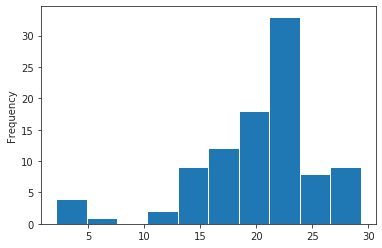

In [192]:
plankton['mu.c.opt.list'].plot(kind='hist')

In [193]:
plankton[plankton['mu.c.opt.list'].between(13, 16)]

,isolate.code,source,isolation.latitude,isolation.longitude,habitat,name,speciesname,former.name.1,former.name.2,strain,...,minqual,maxqual,curvequal,abs.curveskew,rel.curveskew,used.for.optimum.analysis,used.for.tmax.analysis,used.for.tmin.analysis,used.for.niche.width.analysis,used.for.max.growth.rate.analysis
20,26,"South Atlantic, off South Africa",-34.28,17.18,marine,Calcidiscus leptoporus strain NS10-2,Calcidiscus leptoporus,NaN,NaN,NS10-2,...,good,good,good,9.704694,0.001558,1.0,1.0,1.0,1.0,1.0
26,33,"South Atlantic, off Namibia",-23.00,14.00,marine,Calcidiscus leptoporus strain N482-1,Calcidiscus leptoporus,NaN,NaN,N482-1,...,good,good,good,-90.140655,-0.014947,1.0,1.0,1.0,1.0,1.0
132,188,39�36'N 70�06'W (continental shelf edge),39.60,-70.10,marine,Conticribra guillardii clone 7-15,Conticribra guillardii,Thalassiosira guillardi,Cyclotella nana,NaN,...,good,good,good,-70.982503,-0.003186,1.0,1.0,1.0,1.0,1.0
163,233,"off Monhegan Island, Gulf of Maine, USA",43.56,-69.45,marine,Alexandrium fundyense strain MI,Alexandrium fundyense,NaN,NaN,MI,...,good,good,good,-161.059941,-0.017284,1.0,1.0,1.0,1.0,1.0
168,239,Bay of Fundy,44.70,-66.51,marine,Alexandrium fundyense strain BoF,Alexandrium fundyense,NaN,NaN,BoF,...,good,good,good,-138.562847,-0.012760,1.0,1.0,1.0,1.0,1.0
169,240,Northeast Pacific,45.00,-145.00,marine,Pseudo-nitzschia granii,Pseudo-nitzschia granii,NaN,NaN,NaN,...,good,good,good,-4.141825,-0.000537,1.0,1.0,1.0,1.0,1.0
178,256,"Friday Harbour, WA, USA",48.54,-123.01,marine,Skeletonema costatum clone FHS 3,Skeletonema costatum,NaN,NaN,NaN,...,good,good,good,-309.835196,-0.014434,1.0,1.0,1.0,1.0,1.0
297,422,"obtained from MBL, Plymouth",NaN,NaN,marine,Emiliania huxleyi clone P3,Emiliania huxleyi,Coccolithus huxleyi,NaN,NaN,...,good,good,good,-270.539982,-0.017748,0.0,0.0,0.0,1.0,0.0
399,544,"Gulf of Naples, Italy",40.49,14.14,marine,Thalassiosira rotula strain CCMP3264,Thalassiosira rotula,NaN,NaN,CCMP3264,...,good,good,good,-309.766019,-0.012502,1.0,1.0,1.0,1.0,1.0
407,553,"North Atlantic, off Portugal",39.50,-9.33,marine,"Conticribra weissflogii strain CCMP1053, SA",Conticribra weissflogii,Thalassiosira weissflogii,NaN,"CCMP1053, SA",...,good,good,good,-174.107608,-0.019239,1.0,1.0,1.0,1.0,1.0


In [247]:
sample_loc = 178

In [191]:
plankton.columns

Index(['isolate.code', 'source', 'isolation.latitude', 'isolation.longitude',
       'habitat', 'name', 'speciesname', 'former.name.1', 'former.name.2',
       'strain', 'clone', 'species', 'genus', 'family', 'order', 'class',
       'phylum', 'kingdom', 'domain', 'comment', 'group', 'mu.rsqrlist',
       'mu.wlist', 'mu.alist', 'mu.blist', 'mu.slist', 'mu.c.opt.list',
       'mu.c.opt.val.list', 'mu.g.opt.list', 'mu.g.opt.val.list', 'mu.n',
       'emp.max.growth', 'tmin', 'tmax', 'minqual', 'maxqual', 'curvequal',
       'abs.curveskew', 'rel.curveskew', 'used.for.optimum.analysis',
       'used.for.tmax.analysis', 'used.for.tmin.analysis',
       'used.for.niche.width.analysis', 'used.for.max.growth.rate.analysis'],
      dtype='object')

## GBIF Occurrences
*For locating PNW species...*

In [84]:
genera = plankton.genus.dropna().unique()
genera

array(['Koliella', 'Klebsormidium', 'Phaeocystis', 'Pseudo-nitzschia',
       'Emiliania', 'Fibrocapsa', 'Gephyrocapsa', 'Calcidiscus',
       'Isochrysis', 'Trichodesmium', 'Pernambugia', 'Skeletonema',
       'Odontella', 'Chaetoceros', 'Rhizosolenia', 'Thalassionema',
       'Leonella', 'Gymnodinium', 'Crocosphaera', 'Helicotheca',
       'Karenia', 'Thalassiosira', 'Synechococcus', 'Amphiprora',
       'Leptocylindrus', 'Prochlorococcus', 'Chattonella', 'Akashiwo',
       'Cochlodinium', 'Biceratium', 'Neoceratium', 'Peridinium',
       'Prorocentrum', 'Conticribra', 'Cylindrotheca', 'Alexandrium',
       'Micromonas', 'Diacronema', 'Pleurochrysis', 'Proboscia',
       'Chryosochromulina', 'Nannochloris'], dtype=object)

In [85]:
genera = [pygbif.species.name_lookup(q=g, rank='genus') for g in genera]

In [86]:
genera = [g for g in genera if len(g['results']) > 0]

In [92]:
genera = [max(g['results'], key=lambda x: x['numDescendants']) for g in genera]

In [96]:
[g['key'] for g in genera]

[100257648,
 2638318,
 3202265,
 156106086,
 3202210,
 157137562,
 7886820,
 3202194,
 3202305,
 135291666,
 7986990,
 3193372,
 3191919,
 3192923,
 3236591,
 8242378,
 157033029,
 3207519,
 102600899,
 7795240,
 3266115,
 9623827,
 3216715,
 2633558,
 3193082,
 3215940,
 3194434,
 100244582,
 7565797,
 155694066,
 135293515,
 7536081,
 8069717,
 8131159,
 7784947,
 3205073,
 100219962,
 3202273,
 4674451,
 3194133,
 2641141]

In [99]:
genera_counts = [pygbif.occurrences.count(taxonKey=g['key']) for g in genera]

In [100]:
genera_counts

[0,
 1260,
 15529,
 0,
 16685,
 0,
 33714,
 31506,
 1281,
 0,
 18,
 63424,
 44286,
 246661,
 199674,
 101496,
 0,
 44541,
 0,
 2519,
 5,
 198039,
 18960,
 935,
 62691,
 15007,
 1520,
 0,
 12674,
 0,
 0,
 19577,
 73640,
 105,
 31771,
 23326,
 0,
 464,
 641,
 23761,
 1958]

In [108]:
occs = []
for genus, genus_count in zip(genera, genera_counts):
    print(genus['genus'], genus_count)
    if genus_count > 5:
        occs.append(pygbif.occurrences.search(
            taxonKey=genus['key'],
            decimalLatitude=f"{PNW_LAT.start},{PNW_LAT.stop}",
            decimalLongitude=f"{PNW_LON.start},{PNW_LON.stop}"
        ))
    else: 
        occs.append([])

Koliella 0
Klebsormidium 1260
Phaeocystis 15529
Nitzschia 0
Emiliania 16685
Fibrocapsa 0
Gephyrocapsa 33714
Calcidiscus 31506
Isochrysis 1281
Trichodesmium 0
Pernambugia 18
Skeletonema 63424
Odontella 44286
Chaetoceros 246661
Rhizosolenia 199674
Thalassionema 101496
Leonella 0
Gymnodinium 44541
Crocosphaera 0
Helicotheca 2519
Karenia 5
Thalassiosira 198039
Synechococcus 18960
Amphiprora 935
Leptocylindrus 62691
Prochlorococcus 15007
Chattonella 1520
Akashiwo 0
Cochlodinium 12674
Biceratium 0
Neoceratium 0
Peridinium 19577
Prorocentrum 73640
Conticribra 105
Cylindrotheca 31771
Alexandrium 23326
Micromonas 0
Diacronema 464
Ipsiura 641
Proboscia 23761
Nannochloris 1958


In [120]:
occs = [o for o in occs if type(o) == dict]

In [125]:
max_genus = max(occs, key=lambda x: x['count'])['results'][0]

In [127]:
max_genus['genus']

'Chaetoceros'

In [9]:
max_genus_name = "Skeletonema"

## TPC From Genus

In [10]:
def tpc(T, a, b, z, w):
    '''
    https://science.sciencemag.org/content/sci/suppl/2012/10/25/science.1224836.DC1/Thomas.SM.pdf
    '''
    return a * np.exp(b*T) * (1 - ((T - z)/(w / 2))**2)
def plot_tpc(sample, ax=None):
    T = np.arange(sample['mu.c.opt.list'] - (sample['mu.wlist'] / 2), sample['mu.c.opt.list'] + (sample['mu.wlist'] / 2), 0.1)
    perf = tpc(T, sample['mu.alist'], sample['mu.blist'], sample['mu.c.opt.list'], sample['mu.wlist'])
    try:
        plotTitle = "{} {} [{}]".format(sample.genus, sample.species, sample['isolate.code'])
    except AttributeError as e: 
        plotTitle = ""
    if ax:
        ax.plot(T, perf)
        ax.set_title(plotTitle)
        ax.set_xlabel("$T$")
        sns.despine(ax=ax)
    else:
        plt.plot(T, perf)
        plt.title(plotTitle)
        plt.xlabel("$T$ [${^\circ}C$]")
        sns.despine()

In [9]:
this_genus = plankton[plankton.genus == max_genus_name]

NameError: name 'max_genus_name' is not defined

In [10]:
this_genus

NameError: name 'this_genus' is not defined

## **NOTE** Overrode above analysis and chose a single species

In [8]:
sample_species = this_genus.sample(1).iloc[0]

NameError: name 'this_genus' is not defined

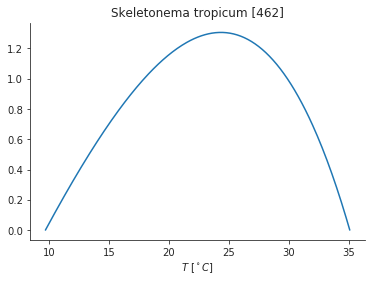

In [14]:
plot_tpc(sample_species)

## Enter MHW and SST

In [14]:
mhw_time = slice('2014-01-01', '2015-05-31')

In [11]:
mhws = xr.open_dataset("../mhw_pipeline/pnw_mhw_intensity.nc").rename({
    '__xarray_dataarray_variable__': 'mhw_intensity'
})


In [12]:
mhws

<xarray.Dataset>
Dimensions:        (lat: 40, lon: 176, time: 13636)
Coordinates:
  * lat            (lat) float32 40.125 40.375 40.625 ... 49.375 49.625 49.875
  * lon            (lon) float32 -165.875 -165.625 ... -122.375 -122.125
  * time           (time) datetime64[ns] 1981-09-01 1981-09-02 ... 2018-12-31
Data variables:
    mhw_intensity  (lat, lon, time) float64 ...

In [16]:
mhw_recent = mhws.sel(time=mhw_time)

In [24]:


mhw_count = mhw_recent.median(dim='time').mhw_intensity

/srv/conda/envs/notebook/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


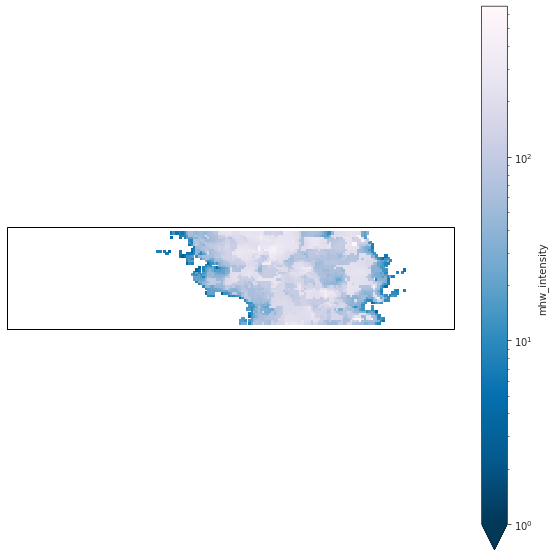

In [25]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.Mercator().GOOGLE)
plot = mhw_count.plot(norm=colors.LogNorm(vmin=1, vmax=mhw_count.max()), cmap='PuBu_r', ax=ax)

In [26]:
mhw_count.lon.max()

<xarray.DataArray 'lon' ()>
array(-122.125)

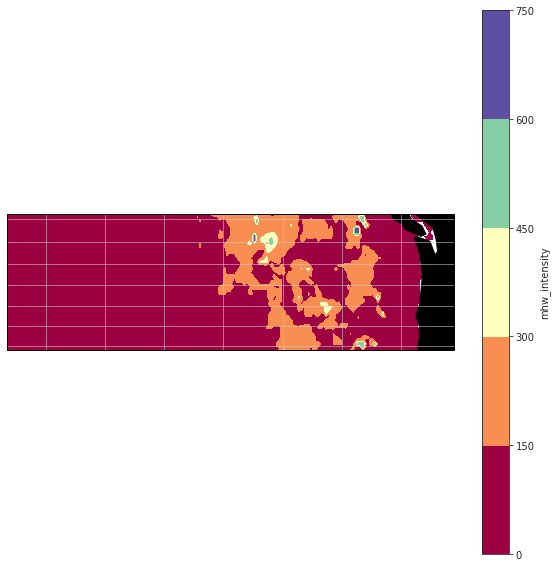

In [27]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.Mercator().GOOGLE)
mhw_count.plot.contourf(cmap='Spectral', ax=ax, transform=ccrs.PlateCarree())
ax.gridlines(alpha=0.7)
ax.add_feature(cf.COASTLINE, facecolor='black')

### SST

In [237]:
fs = gcsfs.GCSFileSystem(project=GCP_PROJECT_ID, token="/home/jovyan/gc-pangeo.json")
oisst = xr.open_zarr(fs.get_mapper(OISST_GCP))
oisst = oisst.assign_coords(lon=(((oisst.lon + 180) % 360) - 180)).sortby('lon')

In [238]:
PNW_LAT = slice(mhw_count.lat.min(), mhw_count.lat.max())
PNW_LON = slice(mhw_count.lon.min(), mhw_count.lon.max())

In [39]:
oisst_pnw = oisst.sel(lat = PNW_LAT, lon = PNW_LON).persist()


In [40]:
recent_sst = oisst_pnw.sel(time=mhw_time)

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.7/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)


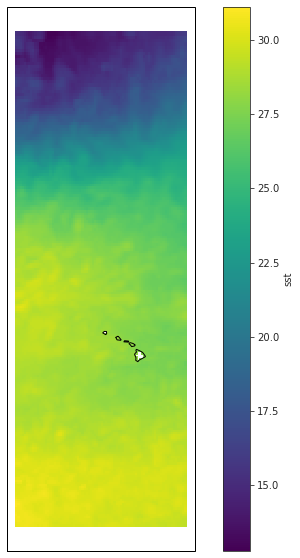

In [289]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.Mercator().GOOGLE)
recent_sst.sst.max(dim='time',).plot( ax=ax, transform=ccrs.PlateCarree())
ax.add_feature(cf.COASTLINE)

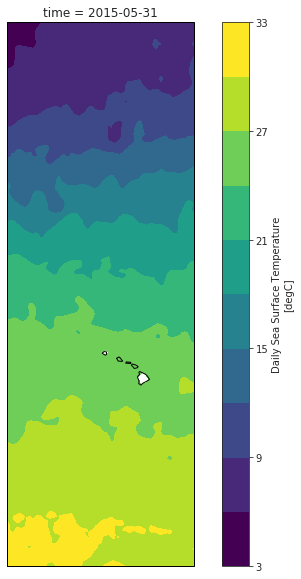

In [292]:

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.Mercator().GOOGLE)
recent_sst.sst.sel(time=mhw_time.stop).plot.contourf( ax=ax, transform=ccrs.PlateCarree(), levels=10)
ax.add_feature(cf.COASTLINE)

In [256]:
dates_for_plot = [pd.to_datetime(mhw_time.start) + timedelta(n) for n in range(len(recent_sst.time))]

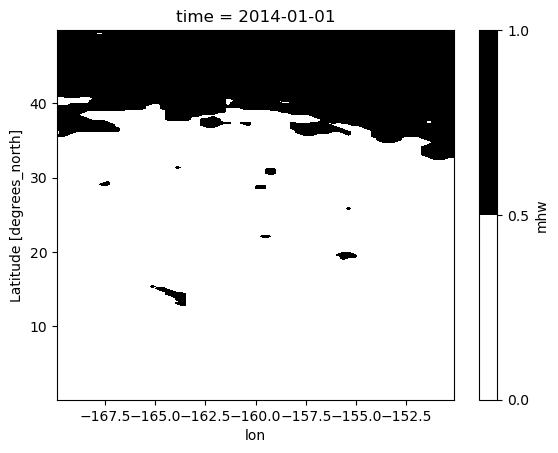

In [101]:
mhws.sel(time=mhw_time.start).mhw.plot.contourf(cmap='binary',vmax=1, levels=3)


MovieWriter ffmpeg unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


2014-01-01 00:00:00
2014-01-01 00:00:00
2014-01-02 00:00:00
2014-01-03 00:00:00
2014-01-04 00:00:00
2014-01-05 00:00:00
2014-01-06 00:00:00
2014-01-07 00:00:00
2014-01-08 00:00:00
2014-01-09 00:00:00
2014-01-10 00:00:00
2014-01-11 00:00:00
2014-01-12 00:00:00
2014-01-13 00:00:00
2014-01-14 00:00:00
2014-01-15 00:00:00
2014-01-16 00:00:00
2014-01-17 00:00:00
2014-01-18 00:00:00
2014-01-19 00:00:00
2014-01-20 00:00:00
2014-01-21 00:00:00
2014-01-22 00:00:00
2014-01-23 00:00:00
2014-01-24 00:00:00
2014-01-25 00:00:00
2014-01-26 00:00:00
2014-01-27 00:00:00
2014-01-28 00:00:00
2014-01-29 00:00:00
2014-01-30 00:00:00
2014-01-31 00:00:00
2014-02-01 00:00:00
2014-02-02 00:00:00
2014-02-03 00:00:00
2014-02-04 00:00:00
2014-02-05 00:00:00
2014-02-06 00:00:00
2014-02-07 00:00:00
2014-02-08 00:00:00
2014-02-09 00:00:00
2014-02-10 00:00:00
2014-02-11 00:00:00
2014-02-12 00:00:00
2014-02-13 00:00:00
2014-02-14 00:00:00
2014-02-15 00:00:00
2014-02-16 00:00:00
2014-02-17 00:00:00
2014-02-18 00:00:00


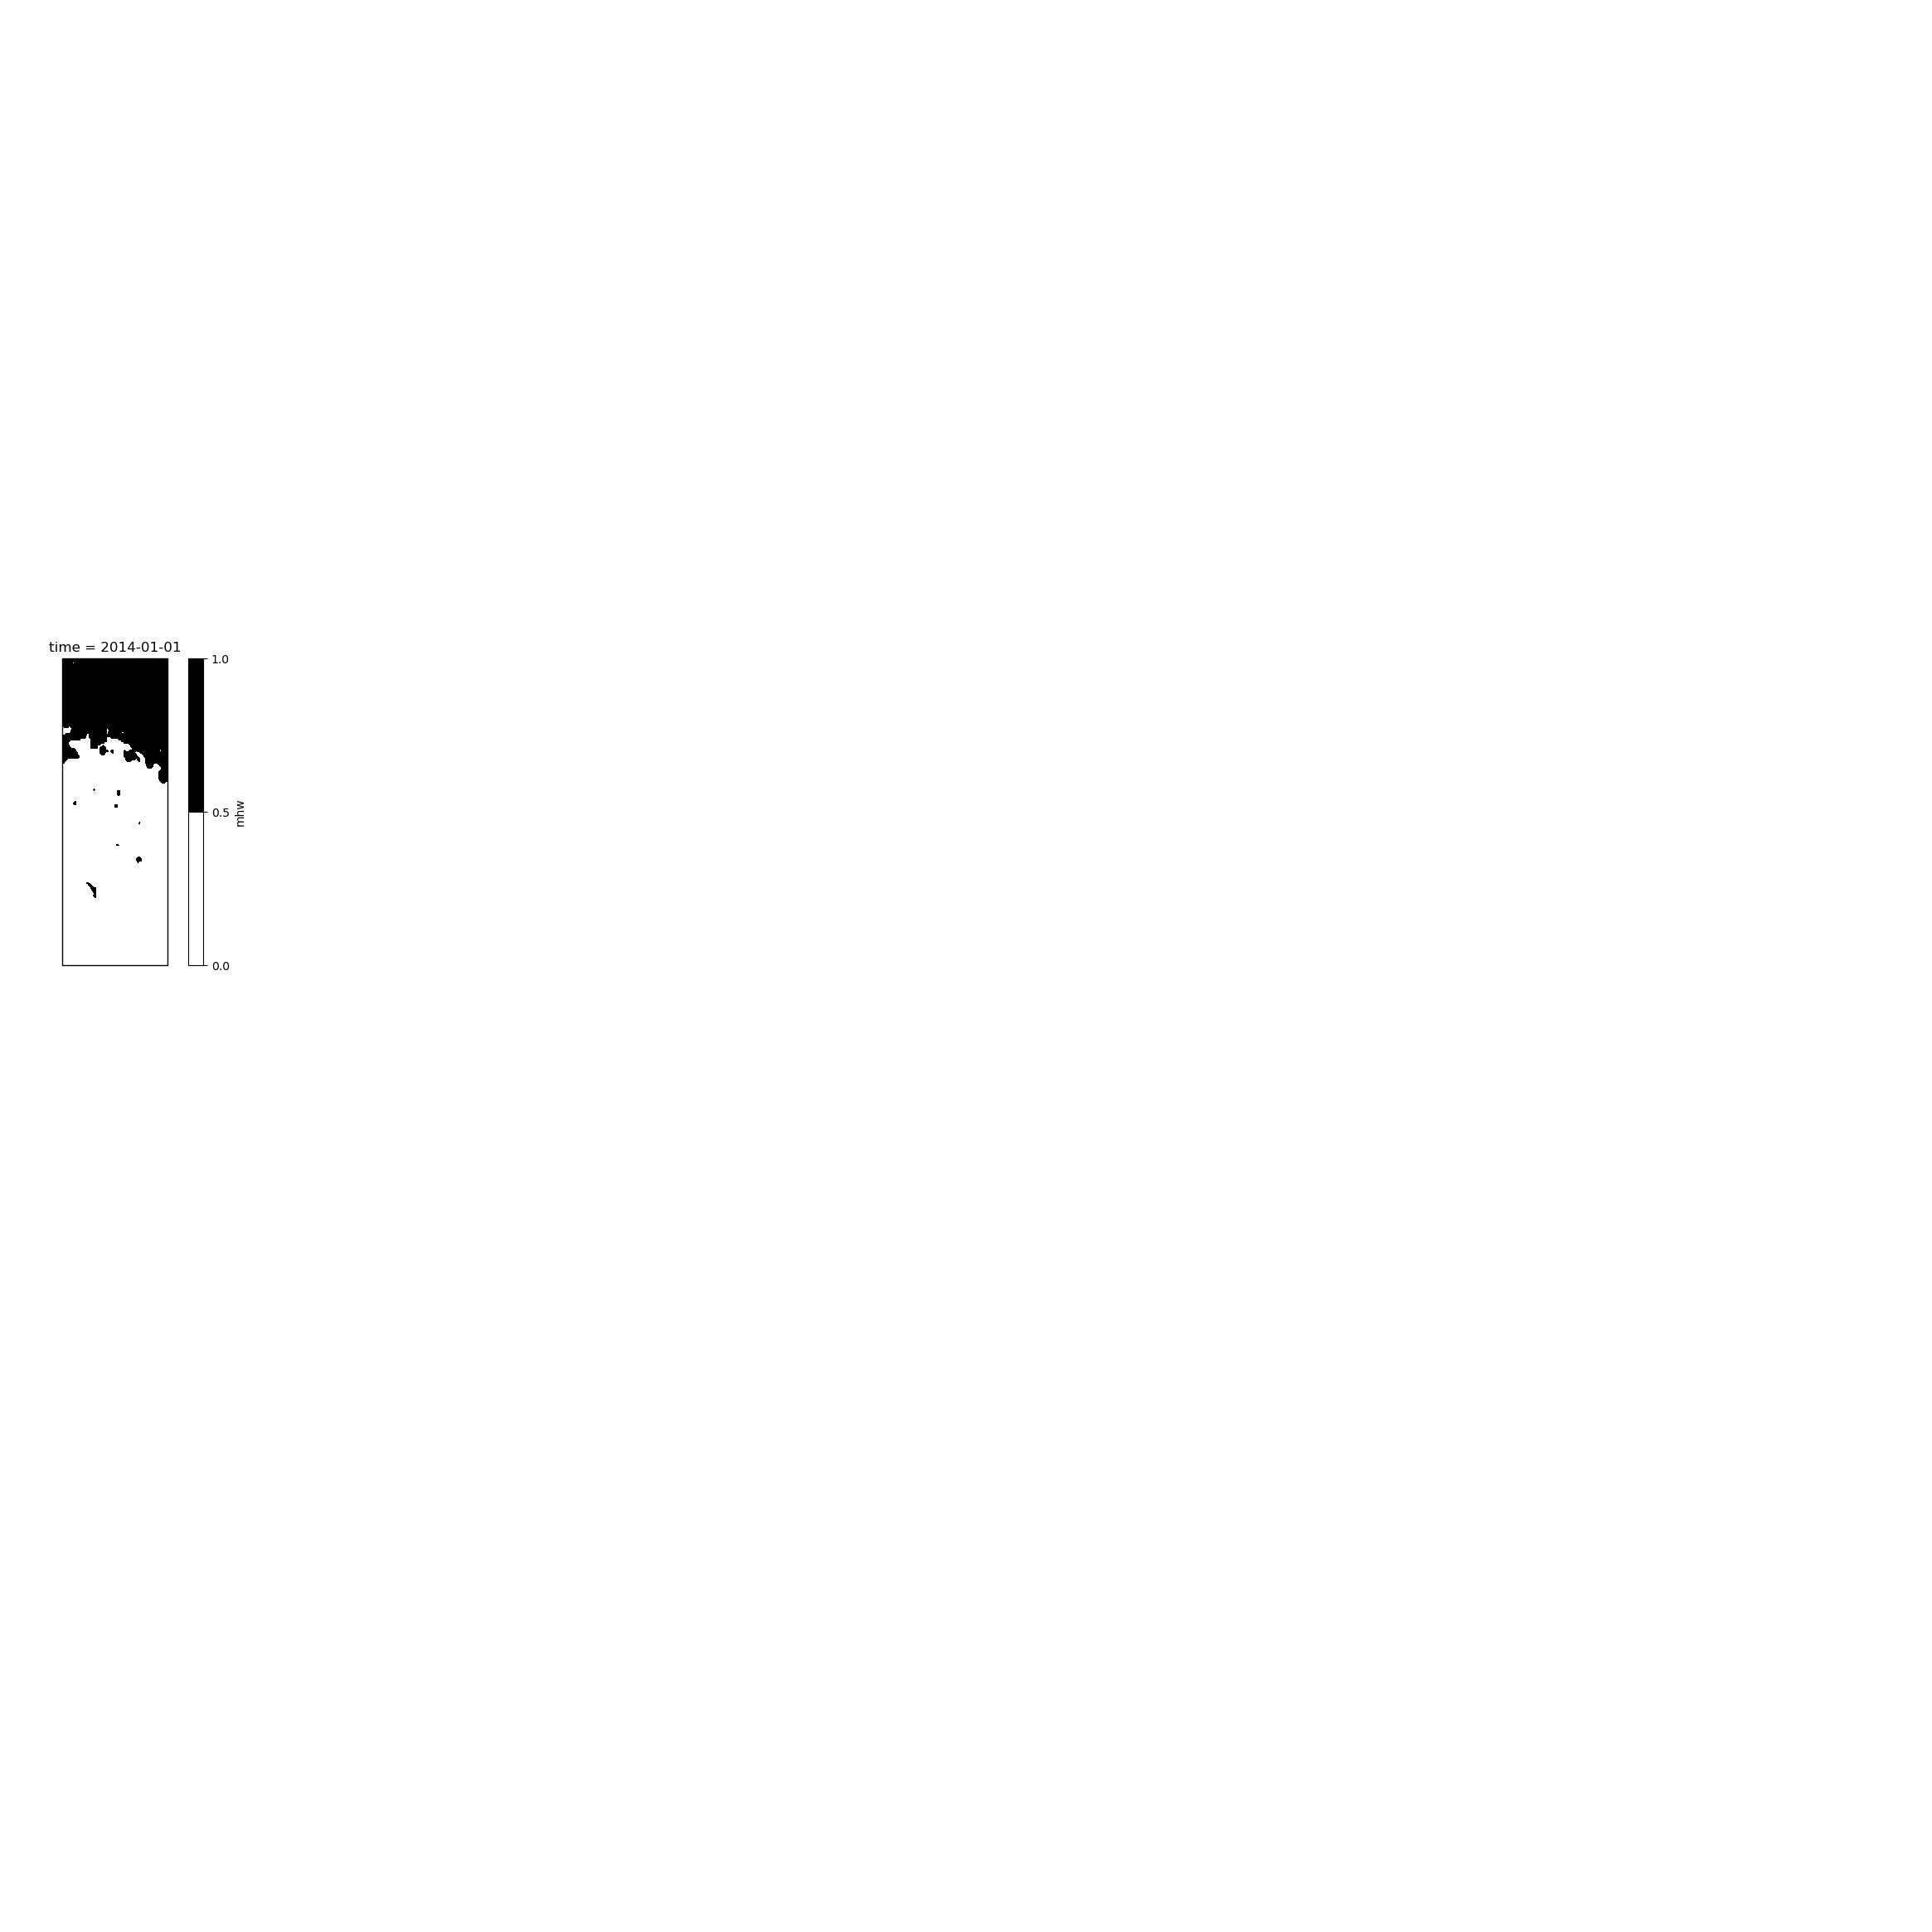

In [102]:
fig = plt.figure()

def anim_func(i):
    fig.clf()
    print(i)
    ax = plt.axes(projection=ccrs.Mercator().GOOGLE)
    mhws.sel(time=i).mhw.plot.contourf(cmap='binary', ax=ax, transform=ccrs.PlateCarree(), vmax=1, levels=3)

    
    
    
anim = FuncAnimation(fig, anim_func, frames=dates_for_plot, interval=100)
anim.save("test.gif")

## Compute Performance Detriment
<!-- We're calling it like this: $$P_{det} = P(T_{opt}) - P(T)$$ where $P(T)$ is the value of the thermal performance curve at temperature $T$.  -->

In [320]:
def perf_det(T, T_opt, tpc, axis=1):
    
    return tpc(T_opt) - tpc(T)

def tsm(T, T_opt, axis):
    return T - T_opt

def plot_det(s, ax):
    this_tpc = partial(tpc, a=s['mu.alist'], b=s['mu.blist'], z=s['mu.c.opt.list'], w=s['mu.wlist'])
    T = np.arange(s['mu.g.opt.list'] - (s['mu.wlist'] / 2), s['mu.c.opt.list'] + (s['mu.wlist'] / 2), 0.1)
    
    perf = this_tpc(T)
    
    max_perf = this_tpc(s['mu.g.opt.list'])
    
    randomT = np.random.choice(T, size=1)
    perf_T = this_tpc(randomT)
    det_T = perf_det(randomT, s['mu.g.opt.list'], this_tpc)

    plt.plot(T, perf)
    plt.vlines(randomT,max_perf, max_perf - det_T)
    plt.axhline(max_perf)

In [321]:
mean_species=sample_species

In [322]:
this_det = partial(
    perf_det,
    T_opt = mean_species['mu.g.opt.list'],
    tpc = partial(tpc,
                  a=mean_species['mu.alist'],
                  b=mean_species['mu.blist'],
                  z=mean_species['mu.c.opt.list'],
                  w=mean_species['mu.wlist'])
)

In [323]:
this_tsm = partial(
    tsm,
    T_opt = mean_species['mu.g.opt.list']
)

In [324]:
ans = recent_sst.sst.reduce(this_det, dim='time').compute()

In [325]:
tsm_ans = recent_sst.sst.reduce(this_tsm, dim='time').compute()

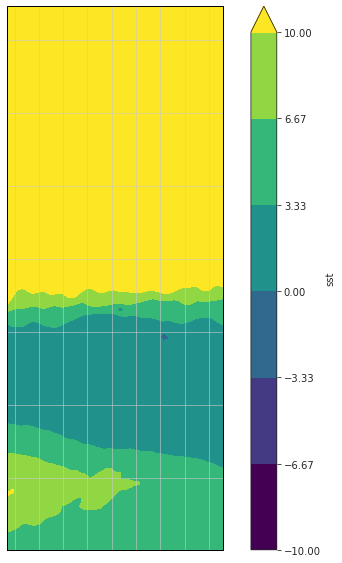

In [362]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.Mercator().GOOGLE)
ans.sel(time=slice('2014-01-01', '2014-05-28')).sum(dim='time').plot.contourf(ax=ax, cmap='viridis', vmin=-10, vmax=10)
ax.gridlines(alpha=0.7)
ax.add_feature(cf.COASTLINE, facecolor='black', zorder=10)
plt.show()

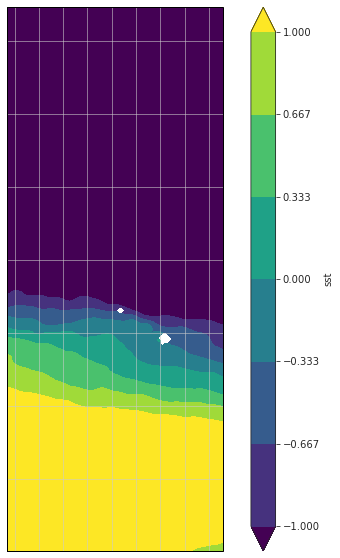

In [357]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.Mercator().GOOGLE)
tsm_ans.mean(dim='time').plot.contourf(ax=ax, cmap='viridis', vmin=-1, vmax=1)
ax.gridlines(alpha=0.7)
ax.add_feature(cf.COASTLINE, facecolor='black')


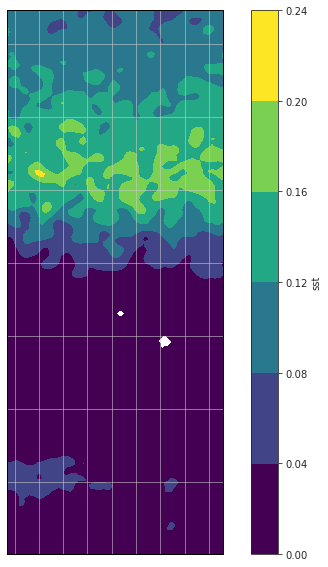

In [356]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.Mercator().GOOGLE)
ans.sel(time=slice('2014-10-25', '2014-12-31')).std(dim='time').plot.contourf(ax=ax)
ax.gridlines(alpha=0.7)
ax.add_feature(cf.COASTLINE, facecolor='black')


In [303]:
example_mhw = slice('2014-01-01', '2014-5-31')
ans_cumsum = ans.sel(time=example_mhw).cumsum(dim='time')
mhw_cumsum = mhws.sel(time=example_mhw).mhw.cumsum(dim='time')

In [304]:
def daterange(start_date, end_date):
    for n in range(int ((pd.to_datetime(end_date) - pd.to_datetime(start_date)).days)):
        yield pd.to_datetime(start_date) + timedelta(n)

MovieWriter ffmpeg unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


2014-01-01 00:00:00
2014-01-01 00:00:00
2014-01-02 00:00:00
2014-01-03 00:00:00
2014-01-04 00:00:00
2014-01-05 00:00:00
2014-01-06 00:00:00
2014-01-07 00:00:00
2014-01-08 00:00:00
2014-01-09 00:00:00
2014-01-10 00:00:00
2014-01-11 00:00:00
2014-01-12 00:00:00
2014-01-13 00:00:00
2014-01-14 00:00:00
2014-01-15 00:00:00
2014-01-16 00:00:00
2014-01-17 00:00:00
2014-01-18 00:00:00
2014-01-19 00:00:00
2014-01-20 00:00:00
2014-01-21 00:00:00
2014-01-22 00:00:00
2014-01-23 00:00:00
2014-01-24 00:00:00
2014-01-25 00:00:00
2014-01-26 00:00:00
2014-01-27 00:00:00
2014-01-28 00:00:00
2014-01-29 00:00:00
2014-01-30 00:00:00
2014-01-31 00:00:00
2014-02-01 00:00:00
2014-02-02 00:00:00
2014-02-03 00:00:00
2014-02-04 00:00:00
2014-02-05 00:00:00
2014-02-06 00:00:00
2014-02-07 00:00:00
2014-02-08 00:00:00
2014-02-09 00:00:00
2014-02-10 00:00:00
2014-02-11 00:00:00
2014-02-12 00:00:00
2014-02-13 00:00:00
2014-02-14 00:00:00
2014-02-15 00:00:00
2014-02-16 00:00:00
2014-02-17 00:00:00
2014-02-18 00:00:00


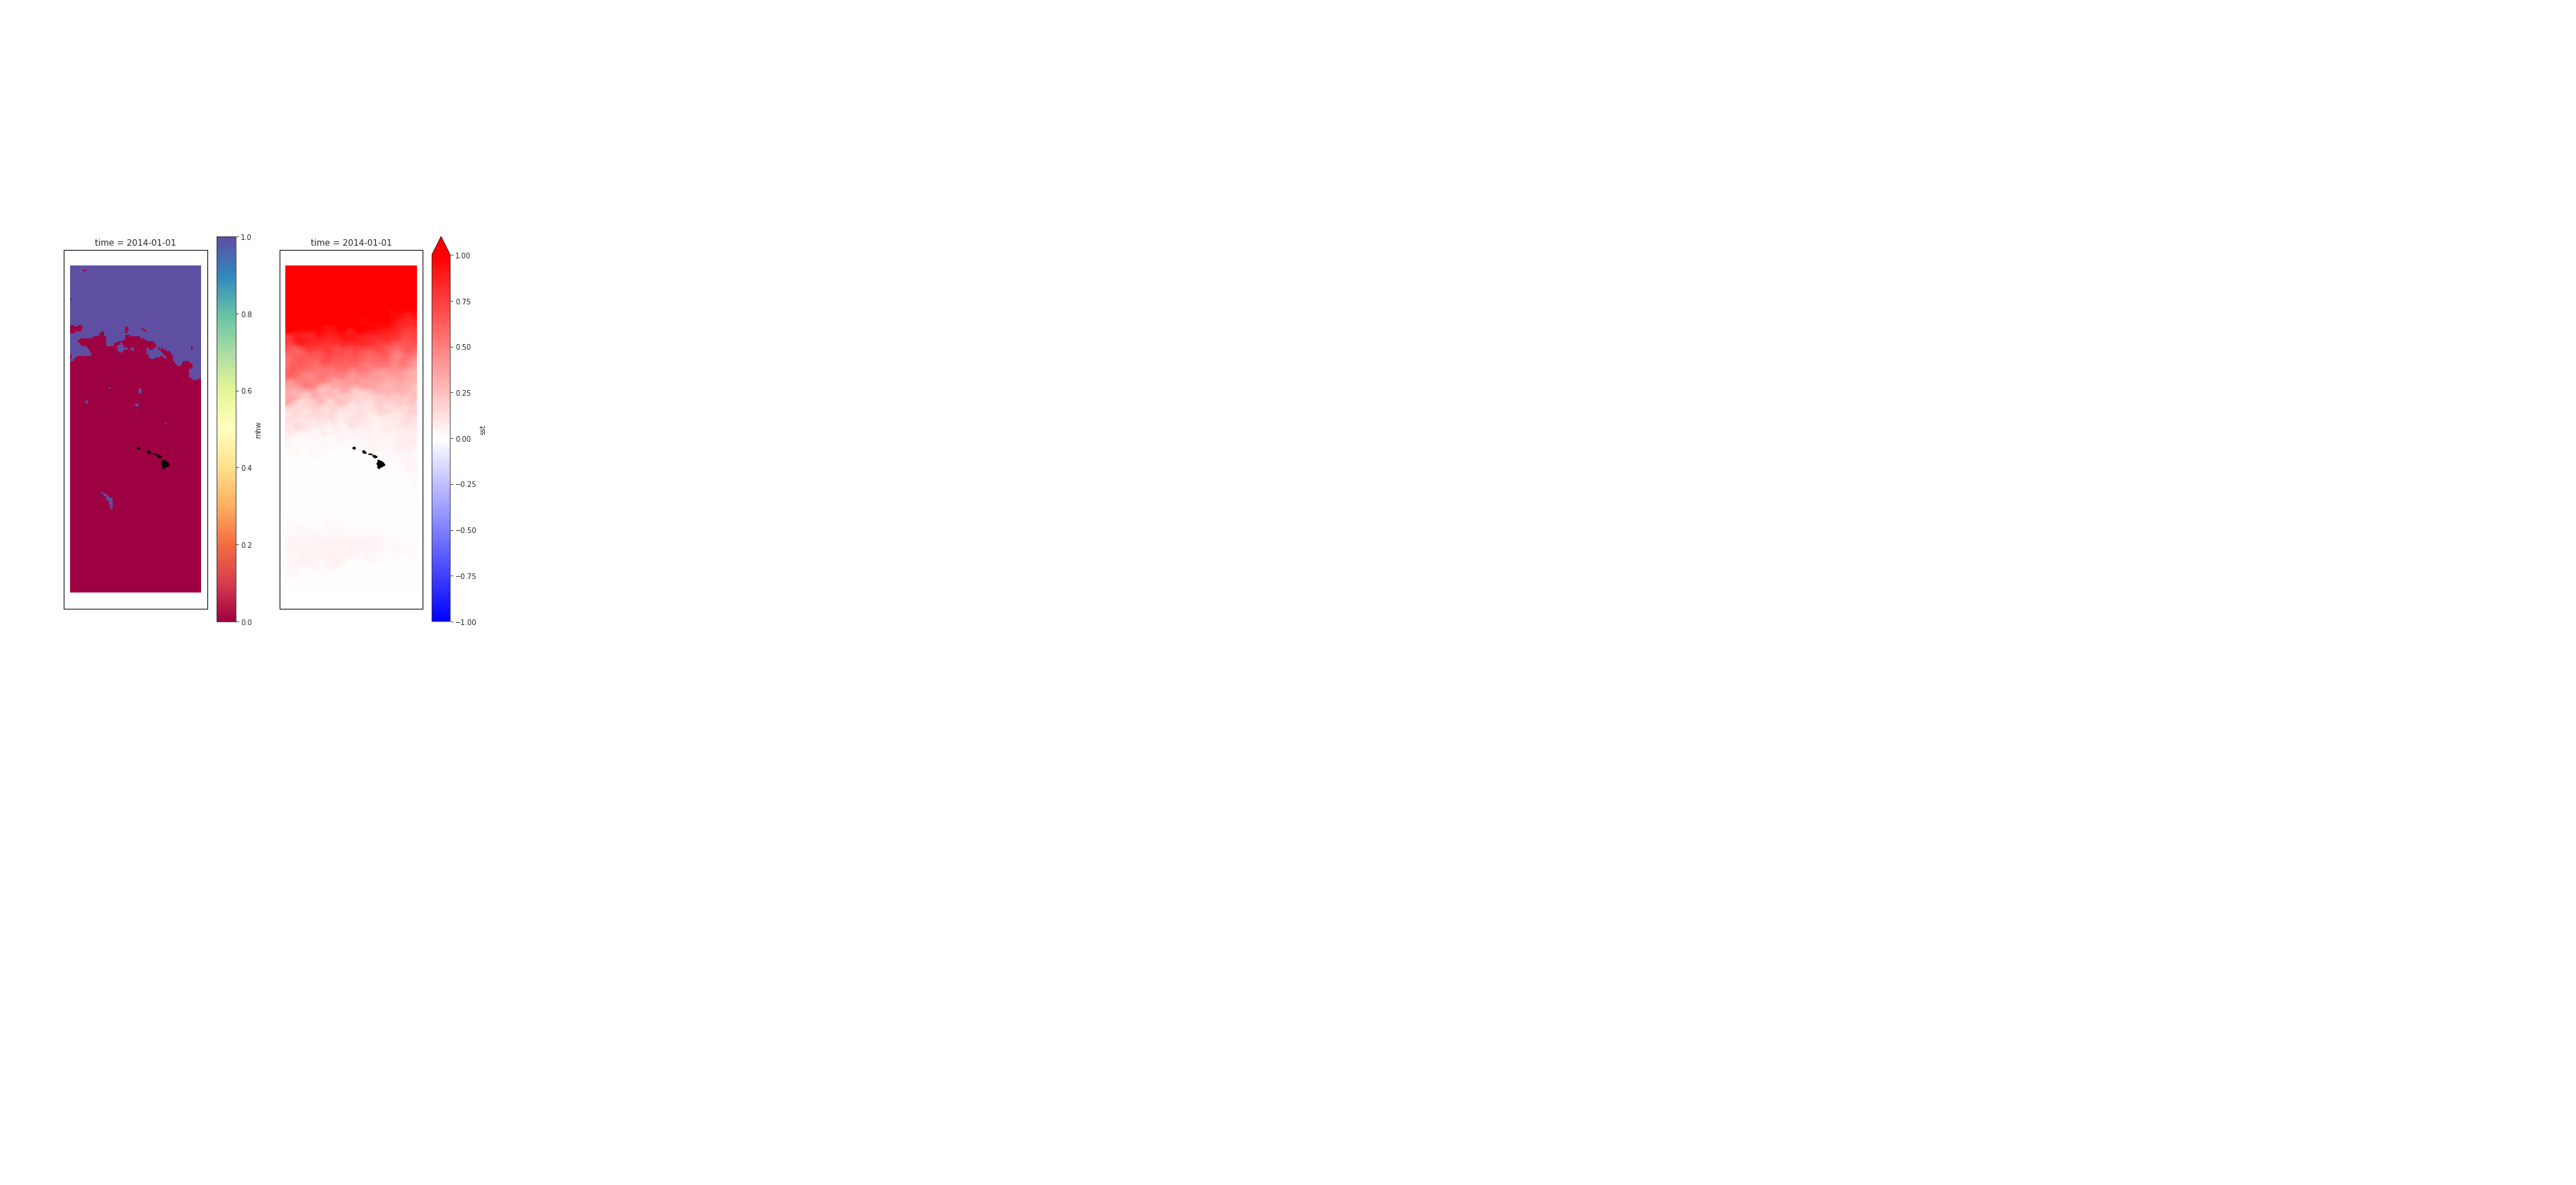

In [311]:
fig = plt.figure(figsize=(10,10))

def anim_func(i):
    print(i)
    fig.clf()
    ax = fig.subplots(nrows =1, ncols = 2, subplot_kw={"projection" : ccrs.PlateCarree()})
    mhws.mhw.sel(time=i).plot(cmap='Spectral', ax=ax[0], transform=ccrs.PlateCarree(), vmax=1)
    ans_norm = colors.DivergingNorm(vmin=-1, vcenter=0, vmax=1)
    ans.sel(time=i).plot(cmap='bwr', ax=ax[1], transform=ccrs.PlateCarree(), norm=ans_norm)
    ax[0].add_feature(cf.COASTLINE, facecolor='black')
    ax[1].add_feature(cf.COASTLINE, facecolor='black')


frames = list(daterange(example_mhw.start, example_mhw.stop))

anim = FuncAnimation(fig, anim_func, frames=frames, interval=100, save_count=len(frames))
anim.save("test.gif")